In [1]:
from pyluos import Robot
from spherical_joint import Actuator
import time
import math
import numpy as np
import threading

In [2]:
r = Robot('/dev/cu.usbserial-DN05NM15')
print(r.modules)

Connected to "/dev/cu.usbserial-DN05NM15".
Sending detection signal.
Waiting for route table...
Robot setup.
-------------------------------------------------
Type                Alias               ID   
-------------------------------------------------
Gate                r_head              1    
ControlledMotor     disk_top            2    
ControlledMotor     disk_middle         3    
ControlledMotor     disk_bottom         4    



### Parameters of the actuator

In [3]:
R0 = [[math.cos(60*math.pi/180),-math.sin(60*math.pi/180),0],[math.sin(60*math.pi/180),math.cos(60*math.pi/180),0],[0,0,1]]
a = Actuator([0,0,93],[0,0,73],33.5,R0)

#r.gate.delay=10
r.disk_bottom.rot_position=False
r.disk_middle.rot_position=False
r.disk_top.rot_position=False

###########Setup############

r.disk_bottom.encoder_res = 3
r.disk_middle.encoder_res = 3
r.disk_top.encoder_res = 3


r.disk_bottom.setToZero()
r.disk_middle.setToZero()
r.disk_top.setToZero()


r.disk_bottom.reduction = 77.35
r.disk_middle.reduction = 77.35
r.disk_top.reduction = 77.35

r.disk_bottom.limit_current = 0.4
r.disk_middle.limit_current = 0.4
r.disk_top.limit_current = 0.4

r.disk_bottom.wheel_size = 62
r.disk_middle.wheel_size = 62
r.disk_top.wheel_size = 62

r.disk_bottom.positionPid = [10,0.04,90.0]
r.disk_middle.positionPid = [10,0.04,90.0]
r.disk_top.positionPid = [10,0.04,90.0]

r.disk_middle.speedPid = [0,0.25,0.5]
r.disk_top.speedPid = [0,0.25,0.5]
r.disk_bottom.speedPid = [0,0.25,0.5]

r.disk_bottom.rot_position_mode = True
r.disk_middle.rot_position_mode = True
r.disk_top.rot_position_mode = True

r.disk_top.rot_position = True
r.disk_middle.rot_position = True
r.disk_bottom.rot_position = True

r.disk_top.rot_speed = True
r.disk_middle.rot_speed = True
r.disk_bottom.rot_speed = True


In [4]:
#If speed must be limited

r.disk_bottom.rot_speed_mode = True
r.disk_middle.rot_speed_mode = True
r.disk_top.rot_speed_mode = True
time.sleep(1)
r.disk_bottom.target_rot_speed = 50
r.disk_middle.target_rot_speed = 50
r.disk_top.target_rot_speed = 50

#### Def Minjerk

In [5]:
def minjerk(initial_position, goal_position, duration):
    initial_velocity=0
    final_velocity=0
    initial_acceleration=0
    final_acceleration=0
    
    a0 = initial_position
    a1 = initial_velocity
    a2 = initial_acceleration / 2

    d1, d2, d3, d4, d5 = [duration ** i for i in range(1, 6)]

    A = np.array((
        (d3, d4, d5),
        (3 * d2, 4 * d3, 5 * d4),
        (6 * d1, 12 * d2, 20 * d3)
    ))
    B = np.array((
        goal_position - a0 - (a1 * d1) - (a2 * d2),
        final_velocity - a1 - (2 * a2 * d1),
        final_acceleration - (2 * a2)
    ))
    X = np.linalg.solve(A, B)

    coeffs = [
            a0,
            a1,
            a2,
            X[0],
            X[1],
            X[2]
    ]

    return lambda t: np.sum([
        c * t ** i
        for i, c in enumerate(coeffs)
    ], axis=0)

### Compliant Mode

In [9]:
r.disk_bottom.compliant = True
r.disk_middle.compliant = True
r.disk_top.compliant = True

In [6]:
r.disk_bottom.compliant = False
r.disk_middle.compliant = False
r.disk_top.compliant = False

### Finds zero with a stop screw

In [14]:
def zero3(): ###Pratique sans la tête
    r.disk_bottom.power_mode = True
    r.disk_middle.power_mode = True
    r.disk_top.power_mode = True

    r.disk_bottom.power_ratio = 0
    r.disk_middle.power_ratio = 0
    r.disk_top.power_ratio = 0

        #Bottom disk zero

    r.disk_bottom.compliant = False
    r.disk_middle.compliant = False
    r.disk_top.compliant = False

    r.disk_bottom.power_ratio = -40
    r.disk_middle.power_ratio = -40
    r.disk_top.power_ratio = -40

    
    time.sleep(1)

    r.disk_bottom.power_ratio = 0
    r.disk_middle.power_ratio = 0
    r.disk_top.power_ratio = 0
    
    r.disk_bottom.setToZero()
    r.disk_middle.setToZero()
    r.disk_top.setToZero()
    
    time.sleep(0.1)
    r.disk_bottom.rot_position_mode = True
    r.disk_middle.rot_position_mode = True
    r.disk_top.rot_position_mode = True

    r.disk_bottom.target_rot_position = 125
    r.disk_middle.target_rot_position = 45+125
    r.disk_top.target_rot_position = 90+125

    time.sleep(0.5)
    
    r.disk_bottom.setToZero()
    r.disk_middle.setToZero()
    r.disk_top.setToZero()
    
    time.sleep(0.1)
    
    q11,q12,q13 = a.get_angles_from_vector([0,0,1],0)
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13

### Finds zeros with stops in the gears

In [11]:
r.disk_bottom.rot_speed_mode = True
r.disk_middle.rot_speed_mode = True
r.disk_top.rot_speed_mode = True
time.sleep(0.5)
r.disk_bottom.target_rot_speed = 60
r.disk_middle.target_rot_speed = 60
r.disk_top.target_rot_speed = 60

dur = 2
r.disk_bottom.sampling_freq = 100
r.disk_middle.sampling_freq = 100
r.disk_top.sampling_freq = 100

fq1 = minjerk(0, -360, dur)
fq2 = minjerk(0, -360, dur)
fq3 = minjerk(0, -360, dur)

Q1 = []
Q2 = []
Q3 = []

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    Q1.append(fq1(t))
    Q2.append(fq2(t))
    Q3.append(fq3(t))
    
    time.sleep(0.01)
    
r.disk_top.play()
r.disk_middle.play()
r.disk_bottom.play()
    
r.disk_top.target_rot_position = Q1
r.disk_middle.target_rot_position = Q2
r.disk_bottom.target_rot_position = Q3

time.sleep(0.2)

while (r.disk_bottom.rot_speed < 0 or r.disk_middle.rot_speed < 0 or r.disk_top.rot_speed < 0):
    time.sleep(0.01)

r.disk_bottom.stop()
r.disk_middle.stop()
r.disk_top.stop()
    
r.disk_bottom.setToZero()
r.disk_middle.setToZero()
r.disk_top.setToZero()

time.sleep(0.2)

r.disk_bottom.target_rot_position = 110
r.disk_middle.target_rot_position = 110
r.disk_top.target_rot_position = 110

time.sleep(3)

r.disk_bottom.setToZero()
r.disk_middle.setToZero()
r.disk_top.setToZero()
time.sleep(0.2)

q11,q12,q13 = a.get_angles_from_vector([0,0,1],0)
r.disk_top.target_rot_position = -q11
r.disk_middle.target_rot_position = -q12
r.disk_bottom.target_rot_position = -q13

### Zeros with buttons

In [ ]:
angle = 0

value_top = 0
value_middle = 0
value_bottom = 0

bottom_zero_set = False
middle_zero_set = False
top_zero_set = False

while (bottom_zero_set == False or middle_zero_set == False or top_zero_set == False):

    if top_zero_set == False:
        r.disk_top.target_rot_position = -angle
    if middle_zero_set == False:
        r.disk_middle.target_rot_position = -angle
    if bottom_zero_set == False:
        r.disk_bottom.target_rot_position = -angle
    
    value_top = r.analog_read_P9.volt
    value_middle = r.analog_read_P8.volt
    value_bottom = r.analog_read_P7.volt
        
    if (value_top > 3 and top_zero_set == False):
        r.disk_top.setToZero()
        top_zero_set = True
        r.disk_top.target_rot_position = 0
        print("top ok")

    if (value_middle > 3 and middle_zero_set == False):
        r.disk_middle.setToZero()
        middle_zero_set = True
        r.disk_middle.target_rot_position = 0
        print("middle ok")

    if (value_bottom > 3 and bottom_zero_set == False):
        r.disk_bottom.setToZero()
        bottom_zero_set = True
        r.disk_bottom.target_rot_position = 0
        print("bottom ok")
    
 

    time.sleep(0.005)
    angle+=0.5

time.sleep(1)

r.disk_top.target_rot_position = 0
r.disk_middle.target_rot_position = 0
r.disk_bottom.target_rot_position = 0

______________

In [6]:
angle = 0

value_top = 0
value_middle = 0
value_bottom = 0

bottom_zero_set = False
middle_zero_set = False
top_zero_set = False

r.disk_bottom.target_rot_position = -100
#r.disk_middle.target_rot_position = -100
#r.disk_top.target_rot_position = -100

In [ ]:
while (bottom_zero_set == False or middle_zero_set == False or top_zero_set == False):

    #if top_zero_set == False:
    #    r.disk_top.target_rot_position = -angle
    #if middle_zero_set == False:
    #    r.disk_middle.target_rot_position = -angle
    #if bottom_zero_set == False:
    #    r.disk_bottom.target_rot_position = -angle
    #
    value_top = r.analog_read_P9.volt
    value_middle = r.analog_read_P8.volt
    value_bottom = r.analog_read_P7.volt
        
    if (value_top > 3 and top_zero_set == False):
        r.disk_top.setToZero()
        top_zero_set = True
        r.disk_top.target_rot_position = 0
        print("top ok")

    if (value_middle > 3 and middle_zero_set == False):
        r.disk_middle.setToZero()
        middle_zero_set = True
        r.disk_middle.target_rot_position = 0
        print("middle ok")

    if (value_bottom > 3 and bottom_zero_set == False):
        r.disk_bottom.setToZero()
        bottom_zero_set = True
        r.disk_bottom.target_rot_position = 0
        print("bottom ok")
    
 

    time.sleep(0.005)
    #angle+=0.5

time.sleep(1)

r.disk_top.target_rot_position = 0
r.disk_middle.target_rot_position = 0
r.disk_bottom.target_rot_position = 0

In [6]:
r.disk_top.target_rot_position = -90
r.disk_middle.target_rot_position = -90
r.disk_bottom.target_rot_position = -90
time.sleep(0.5)
r.disk_bottom.setToZero()
r.disk_middle.setToZero()
r.disk_top.setToZero()

In [4]:
while r.analog_read_P9.volt < 3:
    time.sleep(0.01)
print(r.analog_read_P9.volt)

3.26


In [8]:
r.analog_read_P8.refresh_freq

1040.837247181289

In [4]:
r.analog_read_P7.volt

3.25

In [18]:
r.analog_read_P8.volt

3.25

In [6]:
while r.analog_read_P9.volt < 3:
    time.sleep(0.01)
print("ok")

ok


### Initial position

In [21]:
r.disk_bottom.target_rot_position = 0
r.disk_middle.target_rot_position = 0
r.disk_top.target_rot_position = 0

In [9]:
q11,q12,q13 = a.get_angles_from_vector([0,0,1],0)
r.disk_top.target_rot_position = -q11
r.disk_middle.target_rot_position = -q12
r.disk_bottom.target_rot_position = -q13

-59.99999999999999 -60.00000000000001 -59.99999999999997


/Users/augustin/dev/spherical-joint/spherical_joint/spherical_joint/spherical_joint.py:86: RuntimeWarning: invalid value encountered in double_scalars
  vector_norm.append(i/LA.norm(vec))


In [19]:
print(r.disk_top.rot_position, r.disk_middle.rot_position, r.disk_bottom.rot_position)

0.0 0.0 0.23


## Demo 0

#### 4 points of view

In [12]:
dur = 2

q1, q2, q3 = a.get_angles_from_vector([0,0,1],0)

q11, q12, q13 = a.get_angles_from_vector([-0.3, 0.3, 1], -45)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
#time.sleep(2)
################

q11, q12, q13 = a.get_angles_from_vector([-0.3, -0.3, 1], 45)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
    
#time.sleep(2)
################

q11, q12, q13 = a.get_angles_from_vector([0.1, 0.1, 1], 45)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
    
#time.sleep(2)
################

q11, q12, q13 = a.get_angles_from_vector([0.1, -0.1, 1], -45)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
    
#time.sleep(2)
################

q11, q12, q13 = a.get_angles_from_vector([0, 0, 1], 0)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
    
#time.sleep(2)
################



#### Semi-Exorcist

In [11]:
dur = 2

q1, q2, q3 = a.get_angles_from_vector([0,0,1],0)

q11, q12, q13 = a.get_angles_from_vector([0.4, 0, 1], 0)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
    
time.sleep(1)
angle = 0
for i in range(900):
    angle=i/5
    time.sleep(0.001)
    q11,q12,q13 = a.get_angles_from_vector([0.4,0,1],angle)
    
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13

q1, q2, q3 = q11, q12, q13

#time.sleep(2)
################
q11, q12, q13 = a.get_angles_from_vector([-0.4, 0, 1], 0)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
    
#time.sleep(2)
################
q11, q12, q13 = a.get_angles_from_vector([0, 0, 1], 0)

fq1 = minjerk(-q1, -q11, dur)
fq2 = minjerk(-q2, -q12, dur)
fq3 = minjerk(-q3, -q13, dur)

t0 = time.time()
while time.time() - t0 < dur:
    t = time.time() - t0
    r.disk_top.target_rot_position = fq1(t)
    r.disk_middle.target_rot_position = fq2(t)
    r.disk_bottom.target_rot_position = fq3(t)
    
    time.sleep(0.01)
q1, q2, q3 = q11, q12, q13
    

## Demo 1 : Yes/No

2) Yes


In [8]:
t=0
while t < 2.5:
    X=0.3*math.sin(10*t)
    q11,q12,q13 = a.get_angles_from_vector([X,0,1],0)
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13
    time.sleep(0.005)
    t=t+0.005

Fast

In [13]:
t=0
while t < 2.5:
    X=0.4*math.sin(50*t)
    q11,q12,q13 = a.get_angles_from_vector([X,0,1],0)
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13
    time.sleep(0.005)
    t=t+0.005

Test with array

In [9]:
r.disk_top.sampling_freq = 200
r.disk_middle.sampling_freq = 200

r.disk_middle.pause()
r.disk_top.pause()
r.disk_bottom.pause()

top = [[],[]]
middle = [[],[]]
bottom = [[],[]]

t=0
while t < 2.5:
    X=0.2*math.sin(10*t)
    q11,q12,q13 = a.get_angles_from_vector([X,0,1],0)
    top[0].append(-q11)
    middle[0].append(-q12)
    bottom[0].append(-q13)
    t=t+0.005

while len(top[0]) > 200 :
    for i in range(200):
        top[1].append(top[0][i])
        middle[1].append(middle[0][i])
        bottom[1].append(bottom[0][i])
    r.disk_top.target_rot_position = top[1]
    r.disk_middle.target_rot_position = middle[1]
    r.disk_middle.target_rot_position = bottom[1]
    print("len", len(middle[1]))
    time.sleep(0.1)
    top[1] = []
    middle[1] = []
    bottom[1] = []
    T = []
    M = []
    B = []
    for j in range(200,len(top[0])):
        T.append(top[0][j])
        M.append(middle[0][j])
        B.append(bottom[0][j])
        
    top[0] = T
    middle[0] = M
    bottom[0] = B
    
r.disk_top.target_rot_position = top[0]
r.disk_middle.target_rot_position = middle[0]
r.disk_bottom.target_rot_position = bottom[0]


len 200
len 200


In [10]:
r.disk_top.play()
r.disk_middle.play()
r.disk_bottom.play()

1) No

In [13]:
t=0
while t < 2.5:
    angle=20*math.sin(5*t)
    q11,q12,q13 = a.get_angles_from_vector([0.3,0,1],angle)
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13
    time.sleep(0.01)
    t=t+0.01

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 69.943}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 50.057}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 68.801}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 48.918}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 59.256})})
defaultdic

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 48.018}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 28.855}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 45.772})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 47.679}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 28.538}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 45.551})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 57.112}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 37.474}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 51.68})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0268>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 58.089}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 38.414}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 52.312})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 84.591}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 65.042}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 69.716})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x10fe05ea0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 85.413}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 65.904}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 70.275})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 90.64}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 71.442}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 73.875})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x10fe05ea0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 90.203}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 70.975}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 73.571})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a01e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 66.144}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 46.28}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 57.529})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x10fe05ea0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 63.901}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 44.07}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 56.075})})
defaultdic

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 47.105}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 28.004}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 45.176})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x10fe05ea0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a01e0>, {'target_rot_position': 46.955}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 27.864}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 45.078})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 61.542}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 41.762}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 54.547})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0268>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 62.625}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 42.819}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 55.248})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a01e0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 86.45}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a02f0>, {'target_rot_position': 66.995}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 70.982})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 87.176}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a06a8>, {'target_rot_position': 67.761}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 71.48})})
defaultdic

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0400>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 88.388}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 69.044}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 72.313})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fe05ea0>, {'target_rot_position': 87.742}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 68.359}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 71.868})})
defaultd

both

In [14]:
t=0
while t < 2.5:
    angle1=0.1*math.sin(30*t)
    angle2=0.1*math.sin(15*t)
    q11,q12,q13 = a.get_angles_from_vector([0.1+angle1,angle2,1],0)
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13
    time.sleep(0.01)
    t=t+0.01

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 63.567}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 56.433}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0048>, {'target_rot_position': 60.0})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0400>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 64.926}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0048>, {'target_rot_position': 55.775}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 59.313})})
defaultdic

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 64.914}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 51.192}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 63.732})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 64.377}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 51.361}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 64.107})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a02f0>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 64.167}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 60.11}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 55.721})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x10fed6c80>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 63.159}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 60.842}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 55.989})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 59.233}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 58.467}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 62.303})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x10fed6c80>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 60.095}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 58.15}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 61.754})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0268>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 63.758}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0048>, {'target_rot_position': 56.048}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 60.191})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x10fed6c80>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 64.392}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0048>, {'target_rot_position': 54.707}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0158>, {'target_rot_position': 60.88})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 68.72}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 54.834}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 56.599})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 68.795}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 55.215}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 56.152})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 61.483}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 53.941}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 64.536})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0048>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 60.523}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 55.044}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 64.421})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 61.47}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 61.193}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 57.332})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 61.597}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0598>, {'target_rot_position': 60.555}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 57.846})})
defaultdi

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0268>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 62.964}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 56.737}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0048>, {'target_rot_position': 60.296})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0730>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 64.335}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0048>, {'target_rot_position': 56.055}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0400>, {'target_rot_position': 59.617})})
defaultd

defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0598>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 65.275}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 52.19}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 62.435})})
defaultdict(<function Robot._push_once.<locals>.<lambda> at 0x1166a0158>, {'disk_top': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x10fed6c80>, {'target_rot_position': 65.296}), 'disk_middle': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0730>, {'target_rot_position': 51.545}), 'disk_bottom': defaultdict(<function Robot._push_once.<locals>.<lambda>.<locals>.<lambda> at 0x1166a0268>, {'target_rot_position': 63.023})})
defaultdi

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/augustin/dev/pyluos/pyluos/io/serial_io.py", line 89, in _poll
    to_read = self._serial.in_waiting
  File "/Users/augustin/.virtualenvs/spherical-joint/lib/python3.6/site-packages/serial/serialposix.py", line 467, in in_waiting
    s = fcntl.ioctl(self.fd, TIOCINQ, TIOCM_zero_str)
OSError: [Errno 6] Device not configured



## Demo 2 : Rotation of the platform / Exorcist

In [16]:
q11,q12,q13 = a.get_angles_from_vector([0.3,0,1],0)
r.disk_top.target_rot_position = -q11
r.disk_middle.target_rot_position = -q12
r.disk_bottom.target_rot_position = -q13

time.sleep(1)
angle = 0
for i in range(1800):
    angle=i/5
    time.sleep(0.001)
    q11,q12,q13 = a.get_angles_from_vector([0.3,0,1],angle)
    
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13

time.sleep(1)
q11,q12,q13 = a.get_angles_from_vector([0,0,1],0)
r.disk_bottom.target_rot_position = -q11
r.disk_middle.target_rot_position = -q12
r.disk_top.target_rot_position = -q13

WIP : send an array to the target_rot_pos

In [16]:
q11,q12,q13 = a.get_angles_from_vector([0.3,0,1],0)
r.disk_top.target_rot_position = -q11
r.disk_middle.target_rot_position = -q12
#r.disk_bottom.target_rot_position = -q13

r.disk_top.sampling_freq = 200
r.disk_middle.sampling_freq = 200
#r.disk_bottom.sampling_freq = 100

top_tab = []
middle_tab = []
#bottom_tab = []

time.sleep(1)
angle = 0

r.disk_top.pause()
r.disk_middle.pause()
#r.disk_bottom.pause()

#r.disk_middle.compliant = True
#r.disk_bottom.compliant = True

for i in range(180):
    angle+=1
    q11,q12,q13 = a.get_angles_from_vector([0.3,0,1],angle)
    
    top_tab.append(-q11)
    middle_tab.append(-q12)
    #bottom_tab.append(-q13)
    


In [17]:
r.disk_top.target_rot_position = top_tab
r.disk_middle.target_rot_position = middle_tab
#r.disk_bottom.target_rot_position = np.array(bottom_tab)

In [ ]:
r.disk_top.play()
r.disk_middle.play()
#r.disk_bottom.play()

In [ ]:
time.sleep(1)
q11,q12,q13 = a.get_angles_from_vector([0,0,1],0)
#r.disk_bottom.target_rot_position = -q11
r.disk_middle.target_rot_position = -q12
r.disk_top.target_rot_position = -q13

## Demo 3 : Circle

In [16]:
Rtest = 4
centerTest = 20
angle=0
t=0
a.reset_last_angles()
a.reset_offset()

while t<3*2*math.pi: #TEST CIRCLE PARAMETRIC EQUATION:
    locus = np.array([Rtest*math.cos(t),Rtest*math.sin(t),centerTest])
    t=t+math.pi/100
    
    q11,q12,q13 = a.get_angles_from_vector(locus,angle)
    
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13

    
    time.sleep(0.005)

## Demo 4 : Circle and rotation

In [ ]:
Rtest = 4
centerTest = 10
angle=0
t=0

a.reset_last_angles()
a.reset_offset()

while t<2*2*math.pi:
    locus = np.array([Rtest*math.cos(t),Rtest*math.sin(t),centerTest])
    t=t+math.pi/1000
    angle = angle+1
    
    q11,q12,q13 = a.get_angles_from_vector(locus,angle)
    
    r.disk_top.target_rot_position = -q11
    r.disk_middle.target_rot_position = -q12
    r.disk_bottom.target_rot_position = -q13


    time.sleep(0.01)

## Demo 5 : Record and play moves
1) Record and play a pose

In [ ]:
pose = [r.disk_top.rot_position,r.disk_middle.rot_position,r.disk_bottom.rot_position]

In [ ]:
r.disk_top.target_rot_position = pose[0]
r.disk_middle.target_rot_position = pose[1]
r.disk_bottom.target_rot_position = pose[2]

2) Record a move

In [26]:
r.disk_bottom.compliant = True
r.disk_middle.compliant = True
r.disk_top.compliant = True

Input = []
T = []
t=0
top = []
middle = []
bottom = []

def Listener():
    global Input
    Input = input()
    
listener = threading.Thread(target=Listener)
listener.start()
move = []

while True:
    if type(Input) == type(""):
        break
    else :
        move.append([r.disk_top.rot_position,r.disk_middle.rot_position,r.disk_bottom.rot_position])
        t=t+0.005
        T.append(t)
        top.append(move[-1][0])
        middle.append(move[-1][1])
        bottom.append(move[-1][2])
    time.sleep(0.005)

3) Play a move

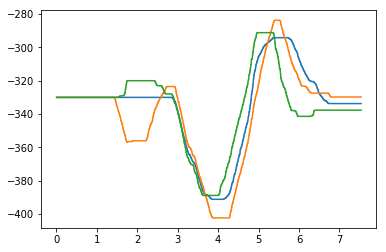

In [24]:
from matplotlib import pyplot as plt
plt.plot(T,top, label = 'top')
plt.plot(T,middle, label='middle')
plt.plot(T,bottom, label = 'bottom')

In [27]:
r.disk_bottom.compliant = False
r.disk_middle.compliant = False
r.disk_top.compliant = False

for i in range(len(move)):
    r.disk_top.target_rot_position = move[i][0]
    r.disk_middle.target_rot_position = move[i][1]
    r.disk_bottom.target_rot_position = move[i][2]
    time.sleep(0.005)